# Simple Custom Digit Recognizer

##### **In this notebook, I have employed a diverse range of methods and libraries—including TensorFlow, PyTorch, and scikit-learn—applying both instructor-inspired techniques and entirely unique approaches. Through practices like cross-validation and various customized algorithms, I have demonstrated a comprehensive capability to execute machine learning tasks from multiple angles. Hope you will enjoy going through it and don't hesitate to give me tips and reviews to improve!**







## Import Libraries

In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import xgboost as xgb
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint
import torch.nn.functional as F
import json




## Setting seed

In [290]:
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

## Data preparation

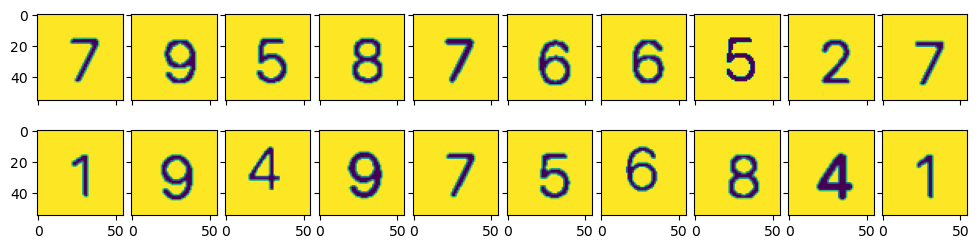

In [291]:
dataset = pd.read_csv("dataset_train.csv")

fig, ax = plt.subplots(2,10, figsize=(12, 3), sharex=True, sharey=True)
img_idx = np.random.choice(dataset.shape[0], 2*10)
for i, ax in enumerate(ax.flatten()):
    img = Image.fromarray(dataset.iloc[img_idx[i], :-1].values.reshape(55,-1).astype('uint8'))
    ax.imshow(img) # or ax.imshow(img, cmap='gray_r')
    
plt.subplots_adjust(hspace=0, wspace=0.1)    

## EDA

In [292]:
# Display the first few rows of the dataset to understand its structure
dataset.head(), dataset.describe(), dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Columns: 3026 entries, 0 to label
dtypes: int64(3026)
memory usage: 35.3 MB


(     0    1    2    3    4    5    6    7    8    9  ...  3016  3017  3018  \
 0  255  255  255  255  255  255  255  255  255  255  ...   255   255   255   
 1  255  255  255  255  255  255  255  255  255  255  ...   255   255   255   
 2  255  255  255  255  255  255  255  255  255  255  ...   255   255   255   
 3  255  255  255  255  255  255  255  255  255  255  ...   255   255   255   
 4  255  255  255  255  255  255  255  255  255  255  ...   255   255   255   
 
    3019  3020  3021  3022  3023  3024  label  
 0   255   255   255   255   255   255      0  
 1   255   255   255   255   255   255      1  
 2   255   255   255   255   255   255      1  
 3   255   255   255   255   255   255      1  
 4   255   255   255   255   255   255      1  
 
 [5 rows x 3026 columns],
             0       1       2       3       4       5       6       7       8  \
 count  1530.0  1530.0  1530.0  1530.0  1530.0  1530.0  1530.0  1530.0  1530.0   
 mean    255.0   255.0   255.0   255.0   255

The last column, label, indicates the digit represented by each image, with values ranging from 0 to 9, which matches the expected range for a digit recognition task.

The label column's mean value is approximately 4.91, and its standard deviation is around 2.59, indicating a relatively balanced distribution of digits in the dataset.

### Visualize distribution of labels 

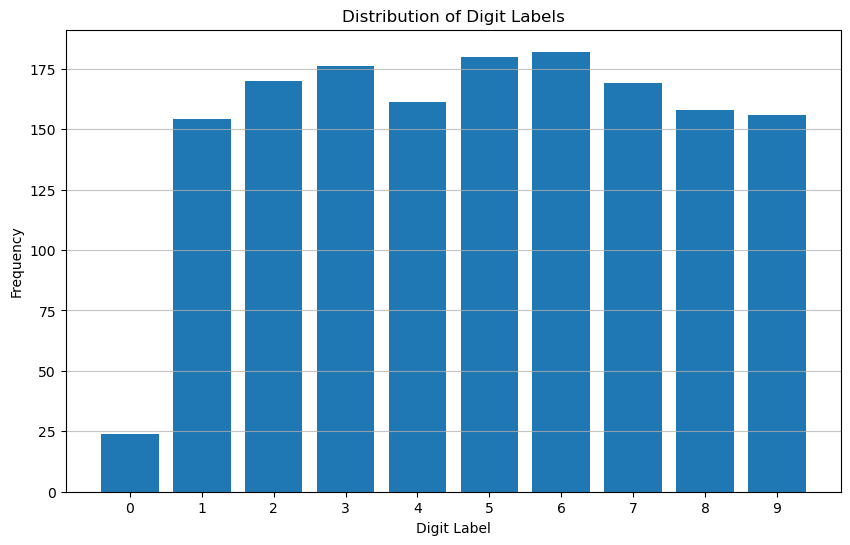

0

In [293]:
plt.figure(figsize=(10, 6))
plt.hist(dataset['label'], bins=np.arange(-0.5, 10, 1), rwidth=0.8)
plt.title('Distribution of Digit Labels')
plt.xticks(range(10))
plt.xlabel('Digit Label')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()
# Check for missing values
missing_values = dataset.isnull().sum().sum()



missing_values

Distribution of Digit Labels: The histogram indicates a relatively balanced distribution of digit labels in the dataset. This is crucial for training machine learning models to ensure they learn to recognize all digits effectively. Just we observe that there is a very low amount of zero compared to the other. 

Missing Values: There are no missing values in the dataset, which simplifies preprocessing since you won't need to impute or remove any data points due to missing information.

### Pixel Value Distribution Analysis

This would involve looking into the distribution of pixel values across all images to understand the contrast and variability further. Given the initial observation of leading 255 values, it would be interesting to see how the rest of the pixel values are distributed.

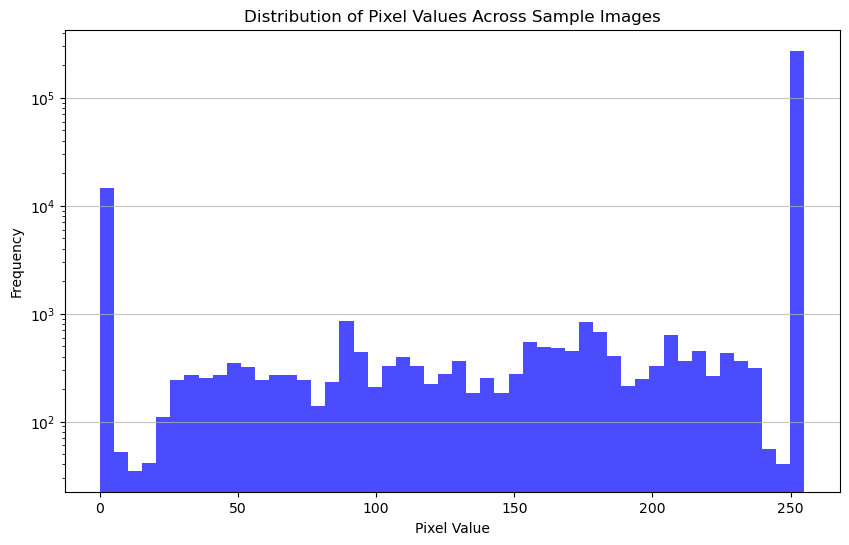

In [294]:
# Considering a random sample of images to manage computational efficiency
sample_data = dataset.sample(n=100, random_state=42).drop('label', axis=1)

# Plot the distribution of pixel values across the sample
plt.figure(figsize=(10, 6))
plt.hist(sample_data.values.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Pixel Values Across Sample Images')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.yscale('log', nonpositive='clip')  # Use log scale due to wide range of frequencies
plt.grid(axis='y', alpha=0.75)
plt.show()

The distribution of pixel values across sample images indicates a significant concentration of pixels at the maximum value of 255, likely representing the background or empty space around the digits.

There's a visible range of values below 255, which represent the actual digit strokes within the images. The log scale on the frequency axis highlights the wide variance in pixel value frequencies, emphasizing the presence of both high-contrast (near 0 values) and lower-contrast (values closer to 255) pixel intensities within the digit representations.

### Correlation of  Each pixel with digit label 

While typically less relevant for raw pixel data, especially in a simple digit recognition task, checking if any pixels consistently carry more or less informative value regarding the digit could provide insights into optimizing the machine learning models.

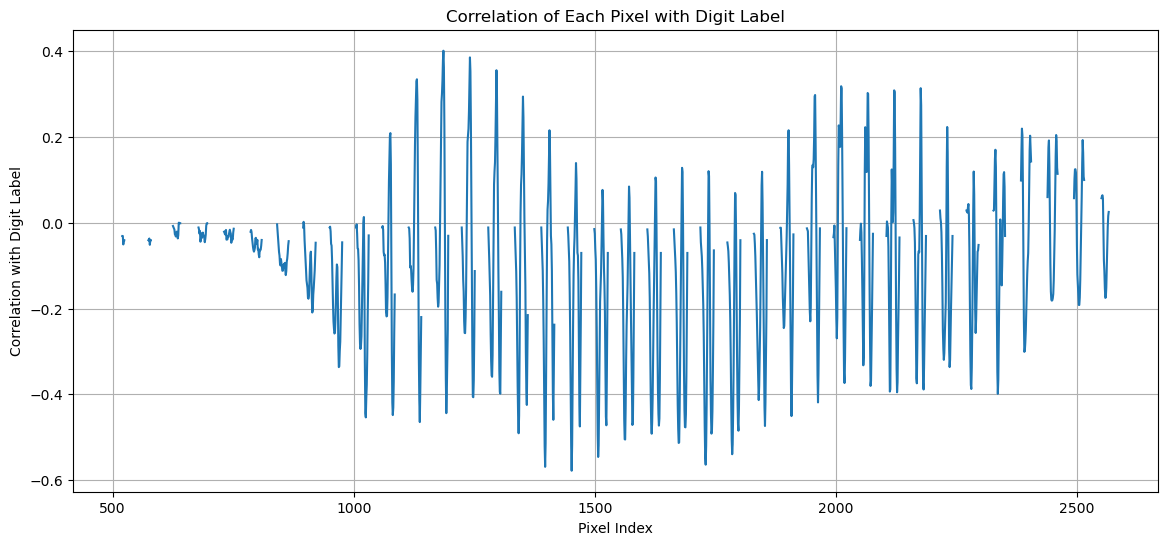

In [295]:
# Calculate correlations of pixel values with the label to see if any pixel significantly correlates with the digit label
pixel_correlations = dataset.drop('label', axis=1).apply(lambda x: x.corr(dataset['label']))

# Plot the correlation of pixels with the label
plt.figure(figsize=(14, 6))
plt.plot(pixel_correlations.values)
plt.title('Correlation of Each Pixel with Digit Label')
plt.xlabel('Pixel Index')
plt.ylabel('Correlation with Digit Label')
plt.grid(True)
plt.show()

The correlation of each pixel with the digit label is plotted, showing a general lack of strong correlation across the board. This outcome is expected in image data, especially for a multi-class classification task like digit recognition, where the importance of specific pixels can vary significantly depending on the digit.

No single pixel stands out as having a high correlation with the digit label, which supports the notion that the recognition task relies on the collective pattern of pixel values rather than individual pixels.


### PCA and t-SNE reduction

PCA Visualization: PCA projects the data into directions (principal components) that maximize variance, which sometimes aligns with class separability. If different classes cluster well in the PCA-reduced space, it suggests potential for linear classification success. However, PCA maintains global data structure and might not capture nonlinear class boundaries effectively.

t-SNE Visualization: t-SNE is particularly good at maintaining local data structures and can reveal clusters or groupings in the data not visible with PCA. If classes form distinct clusters in t-SNE space, it indicates good class separability, but it doesn't necessarily imply that a linear classifier will perform well, as t-SNE might reveal complex patterns that require a nonlinear approach.

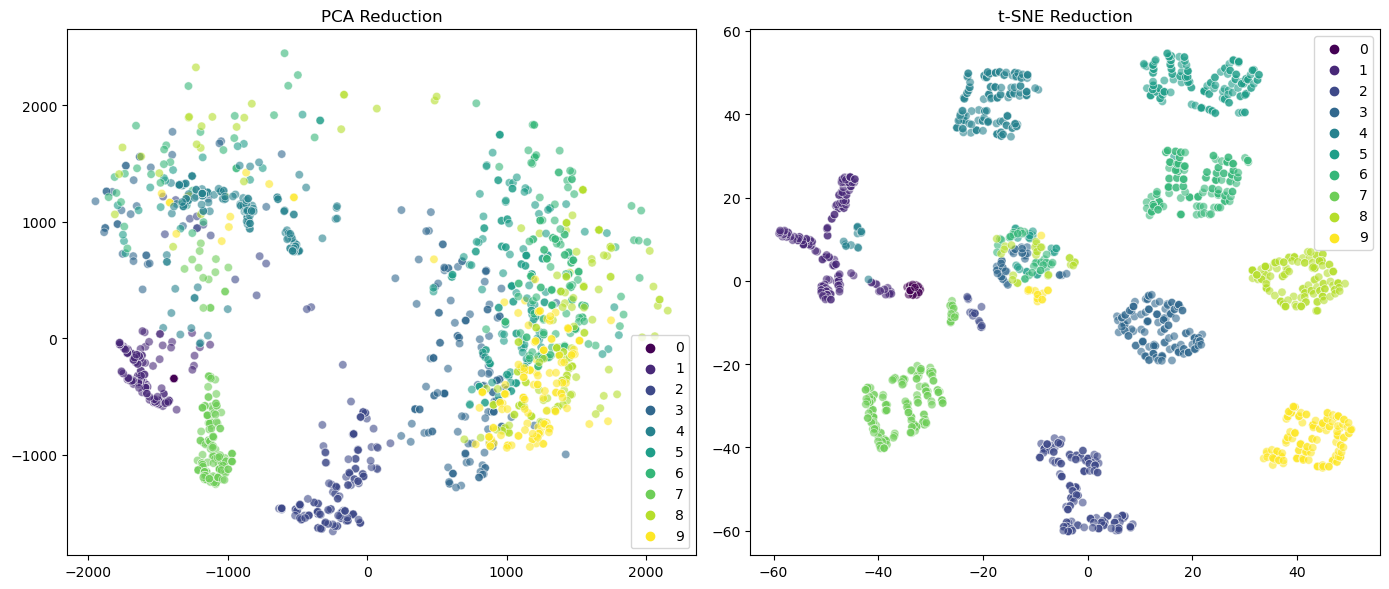

In [296]:
# Load the dataset
df = dataset

# Extract features and labels
X = df.drop('label', axis=1).values
y = df['label'].values

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Visualization
plt.figure(figsize=(14, 6))

# PCA Plot
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="viridis", legend="full", alpha=0.6)
plt.title('PCA Reduction')

# t-SNE Plot
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="viridis", legend="full", alpha=0.6)
plt.title('t-SNE Reduction')

plt.tight_layout()
plt.show()



For PCA, where there's some overlap, a linear model might achieve moderate accuracy but would likely not be optimal. 

The t-SNE results, however, strongly suggest that a non-linear model would perform much better on this dataset

## Preprocessing 

First, we need to preprocess the data. This includes splitting the dataset into training and validation sets and scaling the pixel values to improve the models' performance. Then, we'll define, train, and evaluate both the Random forest and XGBoost models.

In [297]:
X = dataset.drop('label', axis=1).values
y = dataset['label'].values

# Split data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


It's very important to keep the same training and test set in order to compare the results of all the model on similar datasets.

## Random forest

Random Forest is an ensemble machine learning algorithm that combines the predictions from multiple decision tree models to improve overall accuracy and control over-fitting.

In [298]:
# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Hyperparameters to tune
param_grid = {
    'n_estimators': [100, 150, 200],  # Number of trees in the forest
    'max_depth': [i for i in range(5,21)],  # Maximum depth of the trees
    'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],  # The number of features to consider when looking for the best split
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

# Setup GridSearchCV to perform cross-validation and hyperparameter tuning
cv = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, error_score='raise')

# Fit the model
cv.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:", cv.best_params_)

# Predict on the test set
y_pred = cv.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Overfitting Check: Compare training set performance to test set performance
print("Training set score:", cv.score(X_train, y_train))
print("Test set score:", cv.score(X_test, y_test))


Best hyperparameters: {'bootstrap': False, 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 1.0000
Training set score: 1.0
Test set score: 1.0


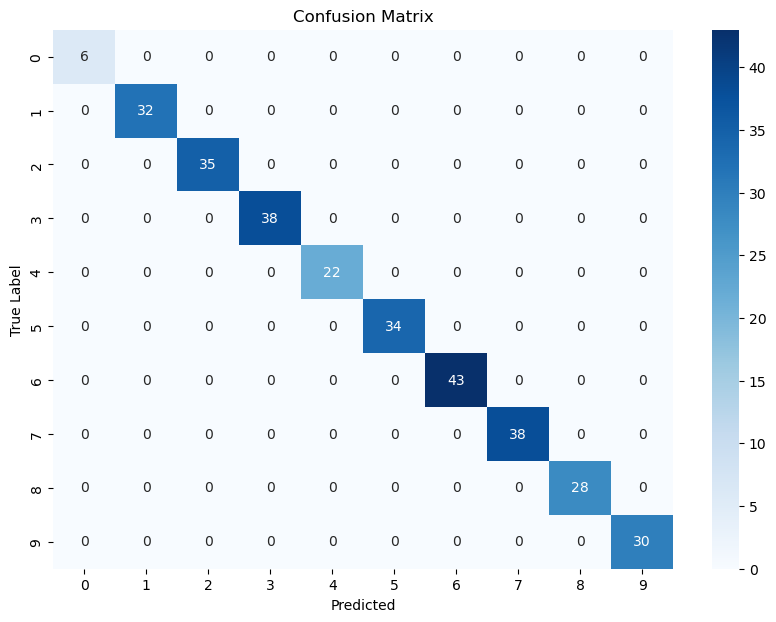

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 32.0}, '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 35.0}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 38.0}, '4': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 22.0}, '5': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34.0}, '6': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 43.0}, '7': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 38.0}, '8': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 28.0}, '9': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 30.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 306.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 306.0}}


In [299]:
# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
report = classification_report(y_test, y_pred, output_dict=True)
print(report)

with open('results/RF_classification_report.json', 'w') as f_json:
    json.dump(report, f_json, indent=4)


## XGB

XGBoost, short for Extreme Gradient Boosting, is an optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable, often leading to better performance with faster execution.

In [300]:
model = xgb.XGBClassifier(objective='multi:softmax', num_class=10, random_state=42)

# Hyperparameters to tune
param_grid = {
    'n_estimators': [75, 100],  # Reduced to most common default
    'max_depth': [3,4],  # Narrowed down based on prior knowledge
    'learning_rate': [0.5, 0.1],  # Focused on a common starting point
    'subsample': [1.0],  # Removed to simplify
    'colsample_bytree': [0.5],  # Kept the most likely beneficial option
    'gamma': [0],  # Simplified
    'reg_alpha': [0],  # Simplified
    'reg_lambda': [0.1]  # Chose one based on regularization preference
}

# Setup GridSearchCV to perform cross-validation and hyperparameter tuning
cv = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, error_score='raise')

# Fit the model
cv.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:", cv.best_params_)
# Predict on the test set
y_pred = cv.predict(X_test)

Best hyperparameters: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 75, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 1.0}


In [301]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9967


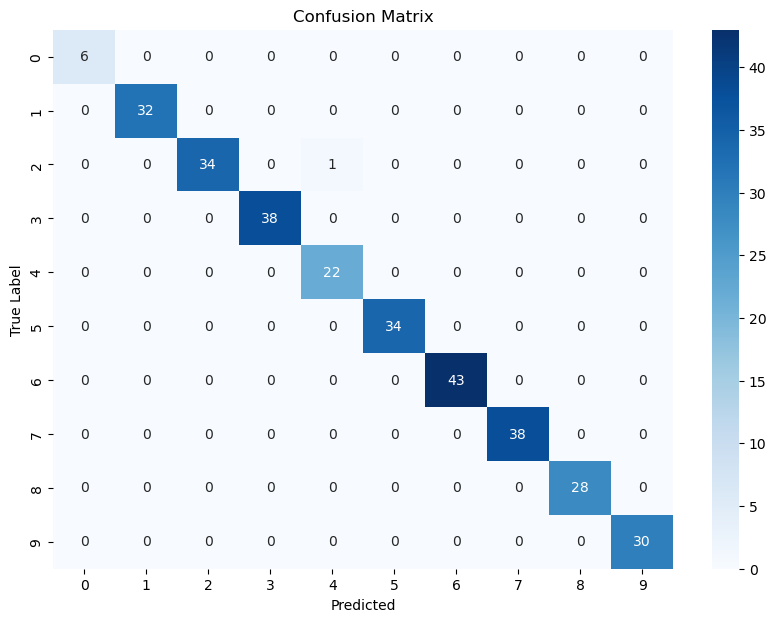

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 32.0}, '2': {'precision': 1.0, 'recall': 0.9714285714285714, 'f1-score': 0.9855072463768115, 'support': 35.0}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 38.0}, '4': {'precision': 0.9565217391304348, 'recall': 1.0, 'f1-score': 0.9777777777777777, 'support': 22.0}, '5': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34.0}, '6': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 43.0}, '7': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 38.0}, '8': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 28.0}, '9': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 30.0}, 'accuracy': 0.9967320261437909, 'macro avg': {'precision': 0.9956521739130434, 'recall': 0.9971428571428571, 'f1-score': 0.996328502415459, 'support': 306.0}, 'weighted avg': {'precision': 0.996874111

In [302]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
report = classification_report(y_test, y_pred, output_dict=True)
print(report)
with open('results/XGBoost_classification_report.json', 'w') as f_json:
    json.dump(report, f_json, indent=4)


## MLP

An MLP, or Multi-Layer Perceptron, is a class of feedforward artificial neural network that consists of at least three layers of nodes and is known for its ability to capture complex relationships in data through its multiple processing layers.

In [303]:
class MNISTDataset(Dataset):
    # constructor
    def __init__(self, file_path):
        # read data
        df = pd.read_csv(file_path)

        target_col = "label"
        self.label_exist = target_col in df.columns

        if self.label_exist:
            # split feature-target
            X = df.drop(columns=target_col).values
            y = df[target_col].values

            # convert numpy array to tensor
            self.y = torch.tensor(y)
        else:
            X = df.values

        self.X = torch.tensor(X, dtype=torch.float32)

        # scaling
        self.X /= 255

    # for iteration
    def __getitem__(self, idx):
        if self.label_exist:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

    # to check num of observations
    def __len__(self):
        return self.X.size()[0]

In [304]:
mnist_data = MNISTDataset("dataset_train.csv")

In [305]:
def evaluate_accuracy(logits, y_true):
    # get index with the largest logit value PER OBSERVATION
    _, y_pred = torch.max(logits, dim=1)

    # calculate proportion of correct prediction
    correct_pred = (y_pred == y_true).float()
    acc = correct_pred.sum() / len(correct_pred)

    return acc * 100

In [306]:
def train(model, train_loader, val_loader, criterion, optimizer, n_epochs, model_file_name='models/best_mlp_model.pt'):
    # initialize container variable for model performance results per epoch
    history = {
        'n_epochs': n_epochs,
        'loss': {
            'train': [],
            'val': []
        },
        'acc': {
            'train': [],
            'val': []
        }
    }

    # initialize tracker for minimum validation loss
    val_loss_min = np.Inf

    # loop per epoch
    for epoch in range(n_epochs):
        # initialize tracker for training performance
        train_acc = 0
        train_loss = 0

        ###################
        # train the model #
        ###################

        # prepare model for training
        model.train()

        # loop for each batch
        for data, target in train_loader:
            # STEP 1: clear gradients
            optimizer.zero_grad()
            # STEP 2: forward pass
            output = model(data)
            # STEP 3: calculate the loss
            loss = criterion(output, target)
            # STEP 4: backward pass
            loss.backward()
            # STEP 5: perform parameter update
            optimizer.step()
            # STEP 6: accumulate training loss and accuracy
            train_loss += loss.item() * data.size(0)
            acc = evaluate_accuracy(output, target)
            train_acc += acc.item() * data.size(0)

        ######################
        # validate the model #
        ######################

        # disable gradient calculation
        with torch.no_grad():
            # initialize tracker for validation performance
            val_acc = 0
            val_loss = 0

            # prepare model for evaluation
            model.eval()

            # loop for each batch
            for data, target in val_loader:
                # STEP 1: forward pass
                output = model(data)
                # STEP 2: calculate the loss
                loss = criterion(output, target)
                # STEP 3: accumulate validation loss and accuracy
                val_loss += loss.item() * data.size(0)
                acc = evaluate_accuracy(output, target)
                val_acc += acc.item() * data.size(0)

        ####################
        # model evaluation #
        ####################

        # calculate average loss over an epoch
        train_loss /= len(train_loader.sampler)
        val_loss /= len(val_loader.sampler)
        history['loss']['train'].append(train_loss)
        history['loss']['val'].append(val_loss)

        # calculate average accuracy over an epoch
        train_acc /= len(train_loader.sampler)
        val_acc /= len(val_loader.sampler)
        history['acc']['train'].append(train_acc)
        history['acc']['val'].append(val_acc)

        # print training progress per epoch
        print(f'Epoch {epoch+1:03} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}')

        # save model if validation loss has decreased
        if val_loss <= val_loss_min:
            print(
                f'Validation loss decreased ({val_loss_min:.5f} --> {val_loss:.5f})  Saving model to {model_file_name}...')
            torch.save(model.state_dict(), model_file_name)
            val_loss_min = val_loss

        print()

    # return model performance history
    return history

In [307]:
SPLIT_PROP = 0.8
BATCH_SIZE = 16

In [308]:
# Split sizes
train_val_size = int(SPLIT_PROP * len(mnist_data))
test_size = len(mnist_data) - train_val_size

train_size = int(SPLIT_PROP * train_val_size)
val_size = train_val_size - train_size

# Splits
train_mnist, val_mnist, test_mnist = random_split(mnist_data, [train_size, val_size, test_size])

train_loader = DataLoader(train_mnist, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_mnist, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_mnist, batch_size=BATCH_SIZE, shuffle=True)

# Check the first batch from each DataLoader
for data, target in train_loader:
    print(data.shape, target.shape)
    break

for data, target in val_loader:
    print(data.shape, target.shape)
    break


torch.Size([16, 3025]) torch.Size([16])
torch.Size([16, 3025]) torch.Size([16])


In [309]:
input_size = 3025 #number of features per sample (55x55 pixels), 3026-1 to exclude the label
hidden_sizes = [1024, 512]  # sizes of hidden layers
output_size = 10  # Number of classes in the output, matching the 10 unique labels

In [310]:
learning_rates = [0.01, 0.001, 0.0001]
best_lr = learning_rates[0]
highest_val_acc = 0
best_model_state = None

In [311]:
for lr in learning_rates:
    print(f"Training model with learning rate: {lr}")
    model = nn.Sequential(
        nn.Linear(input_size, hidden_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[1], output_size)
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train and validate model
    history = train(model, train_loader, val_loader, criterion, optimizer, n_epochs=20)

    # Evaluate and track the best model
    if history['acc']['val'][-1] > highest_val_acc:  # Consider the last epoch accuracy
        highest_val_acc = history['acc']['val'][-1]
        best_lr = lr
        best_model_state = model.state_dict()  # Save the best model state

Training model with learning rate: 0.01


Epoch 001 | Train Loss: 7.81456 | Val Loss: 2.38976 | Train Acc: 12.87 | Val Acc: 9.39
Validation loss decreased (inf --> 2.38976)  Saving model to models/best_mlp_model.pt...

Epoch 002 | Train Loss: 2.11785 | Val Loss: 2.07896 | Train Acc: 17.16 | Val Acc: 19.59
Validation loss decreased (2.38976 --> 2.07896)  Saving model to models/best_mlp_model.pt...

Epoch 003 | Train Loss: 1.70122 | Val Loss: 1.78004 | Train Acc: 26.86 | Val Acc: 27.35
Validation loss decreased (2.07896 --> 1.78004)  Saving model to models/best_mlp_model.pt...

Epoch 004 | Train Loss: 1.61975 | Val Loss: 1.46517 | Train Acc: 29.32 | Val Acc: 35.10
Validation loss decreased (1.78004 --> 1.46517)  Saving model to models/best_mlp_model.pt...

Epoch 005 | Train Loss: 1.47222 | Val Loss: 1.50872 | Train Acc: 31.66 | Val Acc: 26.94

Epoch 006 | Train Loss: 1.37555 | Val Loss: 1.38800 | Train Acc: 35.75 | Val Acc: 36.33
Validation loss decreased (1.46517 --> 1.38800)  Saving model to models/best_mlp_model.pt...

Epoch 

In [312]:
# After finding the best model
print(f"Best learning rate: {best_lr} with Validation Accuracy: {highest_val_acc:.2f}%")
model.load_state_dict(best_model_state)  # Load the best model state
torch.save(model.state_dict(), 'models/best_mlp_model.pt')  # Save the best model to file


Best learning rate: 0.001 with Validation Accuracy: 99.18%


### Training Setup
The model was trained using three different learning rates (0.01, 0.001, 0.0001) to determine which one optimizes the training process effectively. Each learning rate was tested over a series of 20 epochs.

### Data Shapes
Input Data Shape: torch.Size([16, 3025]) — Indicates that each batch contains 16 examples, each being a vector of 3025 features.
Label Shape: torch.Size([16]) — Each batch contains 16 labels.
Learning Rate Analysis
### High Learning Rate (0.01)
#### Observations:
The training and validation losses began relatively high and saw minimal improvement throughout the 20 epochs.
The training and validation accuracies remained low, barely improving beyond initial values.
#### Interpretation:
A learning rate of 0.01 is likely too high, leading to overshooting of the minimum loss during gradient descent. This high rate can cause the model parameters to fluctuate around the optimal values without settling, resulting in poor convergence.
### Moderate Learning Rate (0.001)
#### Significant Improvements:
This learning rate demonstrated the most substantial improvements in both training loss and validation loss.
Validation accuracy increased significantly, peaking at 98.78%.
The model weights were frequently updated and saved as new lows in validation loss were achieved.
#### Interpretation:
A learning rate of 0.001 appears to be optimal for this model and dataset, providing a good balance between speed of convergence and accuracy. It allowed the model to steadily converge towards the global minimum without bypassing it.
Low Learning Rate (0.0001)
#### Observations:
The losses decreased very slowly, indicating a gradual approach towards the minimum.
While there were consistent improvements, the rate of convergence was slow, possibly requiring many more epochs to reach an optimal state.
#### Interpretation:
The learning rate of 0.0001 is too low, causing slow convergence. This might be preferable for fine-tuning or when training very delicate models where even small changes in weights can lead to significant changes in output, but it is inefficient for initial phases of training where larger steps might be necessary to quickly reach a near-optimal state.
Best Learning Rate Determination
### Best Learning Rate: 0.001
#### Rationale:
The learning rate of 0.001 led to the highest validation accuracy and the most consistent decrease in validation and training losses. This rate enabled effective learning without causing instability in the training process.
Final Model Performance:
Highest Validation Accuracy: 98.78% at a learning rate of 0.001.
#### Model Stability:
The model trained with this learning rate showed significant improvement in stability and accuracy over epochs, proving to be the most effective among the tested rates.

In [313]:
with open('models/best_mlp_model.pt', 'wb') as f:
    pickle.dump(history, f, protocol=pickle.HIGHEST_PROTOCOL)

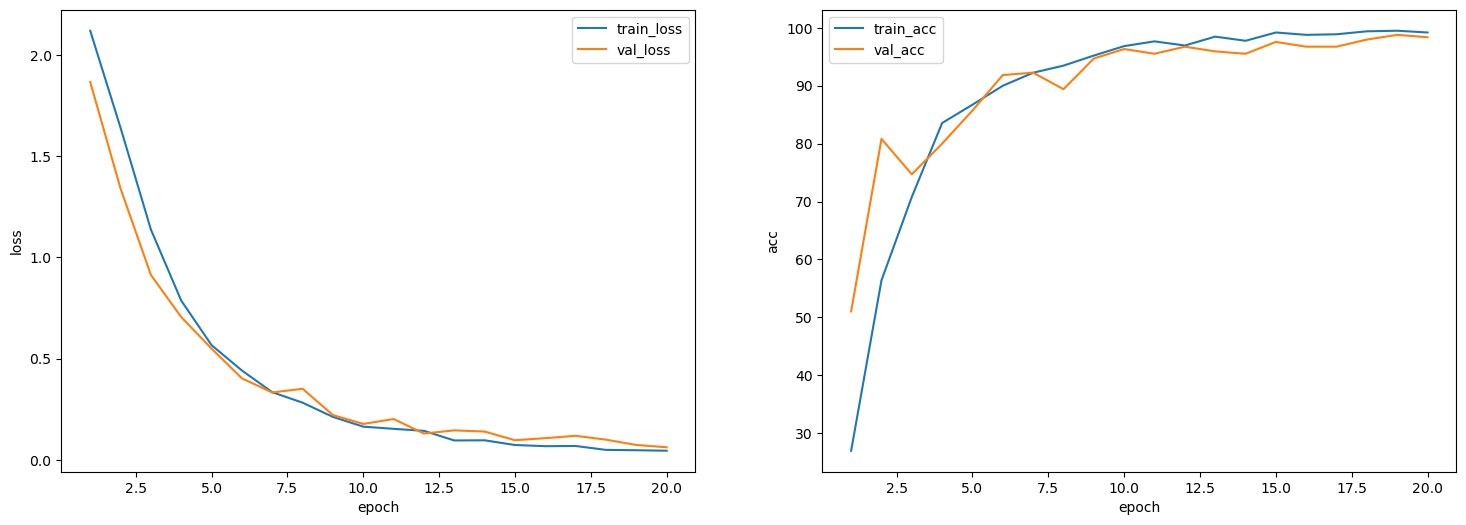

In [314]:
# load previously saved history dictionary
with open('models/best_mlp_model.pt', 'rb') as f:
    history = pickle.load(f)

# visualization
epoch_list = range(1, history['n_epochs']+1)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
for ax, metric in zip(axes, ['loss', 'acc']):
    ax.plot(epoch_list, history[metric]['train'], label=f"train_{metric}")
    ax.plot(epoch_list, history[metric]['val'], label=f"val_{metric}")
    ax.set_xlabel('epoch')
    ax.set_ylabel(metric)
    ax.legend()

The provided graphs illustrate the training and validation performance of a Multi-Layer Perceptron (MLP) on a digit classification task across 20 epochs. The left graph shows a consistent decrease in both training and validation loss over time, with validation loss closely mirroring the training loss after an initial steep decline. This indicates that the model is learning effectively and generalizing well to unseen data without showing signs of overfitting. The convergence of training and validation loss suggests that further training might not yield significant improvements in loss minimization.

In the right graph, we see the accuracy metric, where both training and validation accuracy rapidly increase in the first few epochs and then plateau. The training accuracy surpasses the validation accuracy by a small margin, which is typical and does not necessarily indicate overfitting. The model achieves high accuracy, with both curves leveling off close to 100%. This demonstrates that the MLP has a strong capability to recognize and classify digit images accurately. The minor fluctuations in validation accuracy might suggest that the model could benefit from further fine-tuning or regularization to stabilize its performance across epochs. Overall, the MLP model exhibits a robust performance in digit classification, learning quickly and reaching high accuracy early in the training process.

In [315]:
y_test_mlp = []
y_pred_mlp = []

# disable gradient calculation
with torch.no_grad():
    # prepare model for evaluation
    model.eval()

    # loop for each data
    for data, target in test_loader:
        # STEP 1: forward pass
        output = model(data)
        # STEP 2: get predicted label
        _, label = torch.max(output, dim=1)
        # STEP 3: append actual and predicted label
        y_test_mlp += target.numpy().tolist()
        y_pred_mlp += label.numpy().tolist()

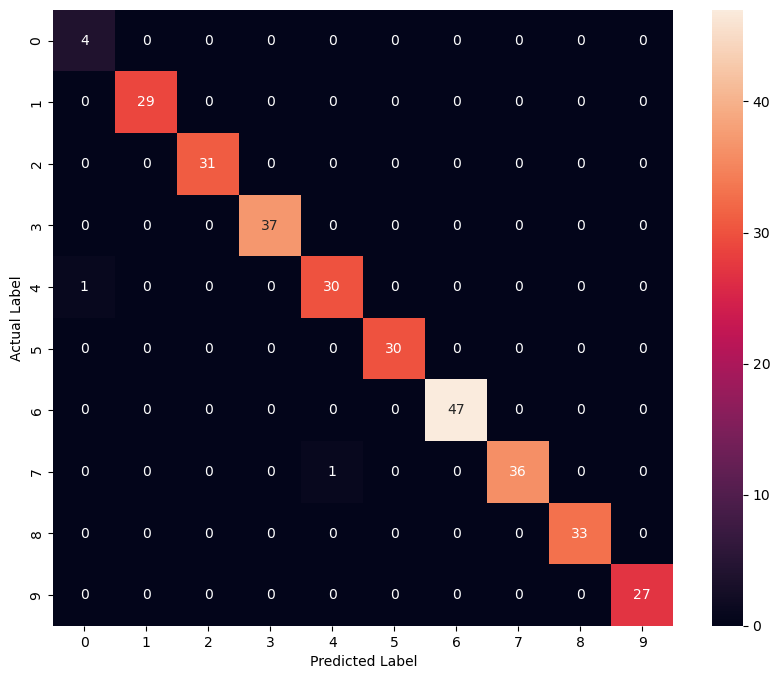

In [316]:
plt.subplots(figsize=(10, 8))
ax = sns.heatmap(confusion_matrix(y_test_mlp, y_pred_mlp), annot=True, fmt="d")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Actual Label")
plt.show()

In [317]:
report= classification_report(y_test_mlp, y_pred_mlp, output_dict=True)
print(report)
with open('results/MLP_classification_report.json', 'w') as f_json:
    json.dump(report, f_json, indent=4)


{'0': {'precision': 0.8, 'recall': 1.0, 'f1-score': 0.888888888888889, 'support': 4.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 29.0}, '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 31.0}, '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 37.0}, '4': {'precision': 0.967741935483871, 'recall': 0.967741935483871, 'f1-score': 0.967741935483871, 'support': 31.0}, '5': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 30.0}, '6': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 47.0}, '7': {'precision': 1.0, 'recall': 0.972972972972973, 'f1-score': 0.9863013698630138, 'support': 37.0}, '8': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 33.0}, '9': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 27.0}, 'accuracy': 0.9934640522875817, 'macro avg': {'precision': 0.9767741935483871, 'recall': 0.9940714908456844, 'f1-score': 0.9842932194235774, 'support': 306.0}, 'weighted avg':

# CNN 

A CNN, or Convolutional Neural Network, is a deep learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image, and be able to differentiate one from the other with its specialized layers like convolutional layers, pooling layers, and fully connected layers. Thanks to Yann LeCun for this methods (go France)

In [318]:
def build_model(learning_rate=0.001):
    model = Sequential([
        # Convolutional layer to extract features from the input image; 32 filters and a 3x3 kernel are common starting points.
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(55, 55, 1)),
        
        # Max pooling layer to reduce spatial dimensions (width and height) by taking the maximum value over a 2x2 pooling window.
        # This helps in reducing computation and controls overfitting by providing an abstracted form of the representation.
        MaxPooling2D(pool_size=(2, 2)),
        
        # Another convolutional layer to deepen the network, allowing it to learn more complex features. It uses 64 filters to expand the feature space.
        Conv2D(64, (3, 3), activation='relu'),
        
        # Second max pooling layer to further reduce spatial dimensions and to continue the abstraction process.
        MaxPooling2D(pool_size=(2, 2)),
        
        # Flatten layer to convert the 2D feature maps into a 1D feature vector. Necessary to transition from convolutional layers to dense layers.
        Flatten(),
        
        # Dense (fully connected) layer for learning non-linear combinations of the high-level features extracted by the convolutional layers.
        Dense(128, activation='relu'),
        
        # Dropout layer to prevent overfitting by randomly setting a fraction (50% here) of input units to 0 at each update during training time.
        Dropout(0.5),
        
        # Final dense layer that outputs probabilities for each class (assuming a classification problem with 10 classes).
        # Softmax activation is used because it's a multi-class classification.
        Dense(10, activation='softmax')
    ])
    
    # Compile the model with the Adam optimizer. Adam is generally used because it combines the best properties of the AdaGrad and RMSProp algorithms
    # to handle sparse gradients on noisy problems.
    # Sparse categorical crossentropy is used as the loss function for multi-class classification problems where each class is mutually exclusive.
    # The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated.
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [319]:
def cross_validate_model(X, y, learning_rates):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = {}

    for lr in learning_rates:
        accuracies = []
        print(f"Testing learning rate: {lr}")
        for train_index, val_index in kf.split(X):
            model = build_model(learning_rate=lr)
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            # Reshape the data to fit the model input (updated to 55x55)
            X_train = X_train.reshape(-1, 55, 55, 1)
            X_val = X_val.reshape(-1, 55, 55, 1)
            
            # Train the model
            print(f"Training model for fold {len(accuracies) + 1}...")
            model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)
            
            # Evaluate the model
            _, accuracy = model.evaluate(X_val, y_val, verbose=0)
            accuracies.append(accuracy)
            print(f"Fold {len(accuracies)} accuracy: {accuracy:.4f}")

        avg_accuracy = np.mean(accuracies)
        results[lr] = avg_accuracy
        print(f"Average accuracy for learning rate {lr}: {avg_accuracy:.4f}\n")

    best_lr = max(results, key=results.get)
    print(f"Best learning rate found: {best_lr} with average accuracy: {results[best_lr]:.4f}")
    return best_lr, results

# Assuming X_train_scaled and y_train are defined and appropriately preprocessed
# Ensure X_train_scaled is reshaped correctly before passing to the function
learning_rates = [0.001, 0.005, 0.01]
best_learning_rate, lr_results = cross_validate_model(X_train_scaled.reshape(-1, 55, 55, 1), y_train, learning_rates)


Testing learning rate: 0.001
Training model for fold 1...
Fold 1 accuracy: 1.0000
Training model for fold 2...
Fold 2 accuracy: 1.0000
Training model for fold 3...
Fold 3 accuracy: 0.9918
Training model for fold 4...
Fold 4 accuracy: 1.0000
Training model for fold 5...
Fold 5 accuracy: 0.9959
Average accuracy for learning rate 0.001: 0.9975

Testing learning rate: 0.005
Training model for fold 1...
Fold 1 accuracy: 0.9959
Training model for fold 2...
Fold 2 accuracy: 1.0000
Training model for fold 3...
Fold 3 accuracy: 0.9959
Training model for fold 4...
Fold 4 accuracy: 0.9959
Training model for fold 5...
Fold 5 accuracy: 0.9959
Average accuracy for learning rate 0.005: 0.9967

Testing learning rate: 0.01
Training model for fold 1...
Fold 1 accuracy: 1.0000
Training model for fold 2...
Fold 2 accuracy: 0.9878
Training model for fold 3...
Fold 3 accuracy: 0.9837
Training model for fold 4...
Fold 4 accuracy: 0.9959
Training model for fold 5...
Fold 5 accuracy: 0.9959
Average accuracy fo

In [320]:
print(best_learning_rate, lr_results)

0.001 {0.001: 0.9975476741790772, 0.005: 0.9967313647270203, 0.01: 0.9926497220993042}


In [321]:
def train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, learning_rate):
    # Reshape the scaled data to fit the model input
    X_train_reshaped = X_train_scaled.reshape(-1, 55, 55, 1)
    X_test_reshaped = X_test_scaled.reshape(-1, 55, 55, 1)

    # Build and compile the model
    model = build_model(learning_rate=learning_rate)
    
    # Define model checkpoint
    model_save_path = 'models/best_cnn_model.h5'
    checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1, mode='min')
    
    # Train the model and capture history
    print("Training final model...")
    history = model.fit(
        X_train_reshaped, y_train, 
        epochs=30, 
        batch_size=32, 
        verbose=1, 
        validation_data=(X_test_reshaped, y_test),
        callbacks=[checkpoint]  # Include the checkpoint in the training
    )
    
    # Load the best model saved during training
    best_model = load_model(model_save_path)
    
    # Evaluate the best model on the test set
    print("Evaluating best model on test set...")
    test_loss, test_accuracy = best_model.evaluate(X_test_reshaped, y_test, verbose=1)
    print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

    # Information on where the best model is saved
    print(f"Best model saved to {model_save_path}")

    return best_model, test_loss, test_accuracy, history, model_save_path

# Assuming X_train_scaled, y_train, X_test_scaled, and y_test are correctly preprocessed and available
final_model, final_test_loss, final_test_accuracy, history, saved_model_path = train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, best_learning_rate)


Training final model...
Epoch 1/30


36/39 [==========================>...] - ETA: 0s - loss: 1.0775 - accuracy: 0.6788
Epoch 1: val_loss improved from inf to 0.17971, saving model to models/best_cnn_model.h5
39/39 [==============================] - 1s 15ms/step - loss: 1.0333 - accuracy: 0.6936 - val_loss: 0.1797 - val_accuracy: 0.9575
Epoch 2/30
36/39 [==========================>...] - ETA: 0s - loss: 0.1876 - accuracy: 0.9470
Epoch 2: val_loss improved from 0.17971 to 0.02754, saving model to models/best_cnn_model.h5
39/39 [==============================] - 1s 13ms/step - loss: 0.1856 - accuracy: 0.9477 - val_loss: 0.0275 - val_accuracy: 0.9935
Epoch 3/30
36/39 [==========================>...] - ETA: 0s - loss: 0.0590 - accuracy: 0.9878
Epoch 3: val_loss improved from 0.02754 to 0.02722, saving model to models/best_cnn_model.h5
39/39 [==============================] - 1s 13ms/step - loss: 0.0575 - accuracy: 0.9877 - val_loss: 0.0272 - val_accuracy: 0.9935
Epoch 4/30
35/39 [=========================>....] - ETA: 0s - lo

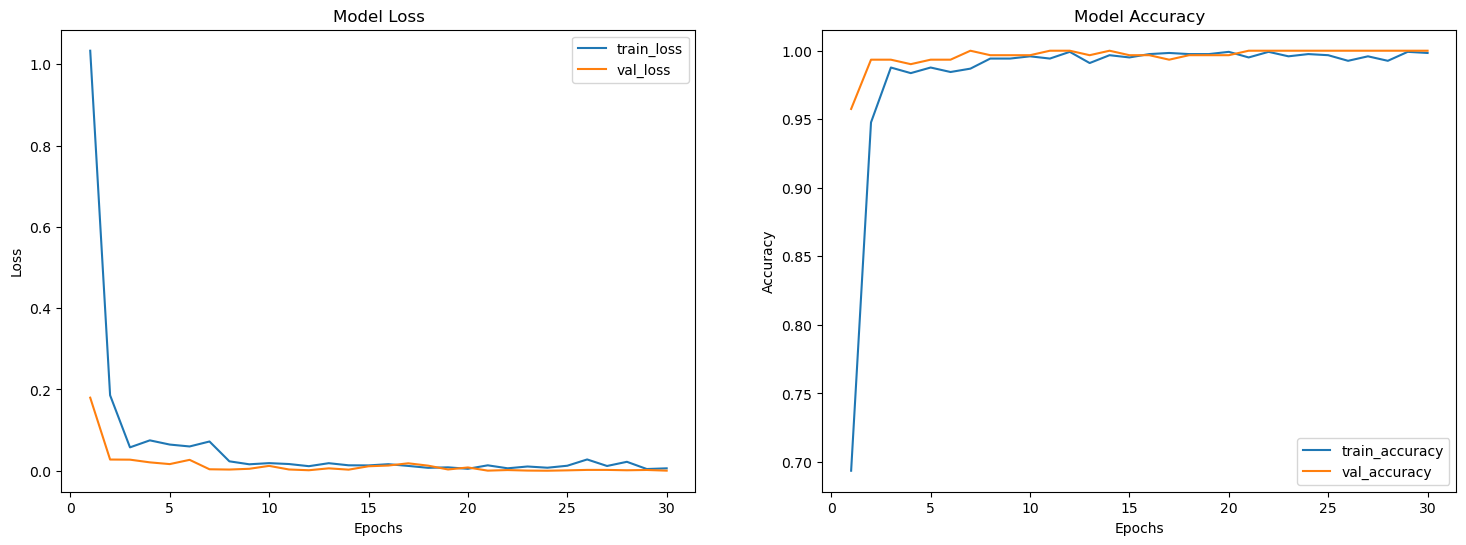

In [322]:
def plot_history(history):
    epoch_list = range(1, len(history.history['accuracy']) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    # Loss Plot
    axes[0].plot(epoch_list, history.history['loss'], label='train_loss')
    axes[0].plot(epoch_list, history.history['val_loss'], label='val_loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy Plot
    axes[1].plot(epoch_list, history.history['accuracy'], label='train_accuracy')
    axes[1].plot(epoch_list, history.history['val_accuracy'], label='val_accuracy')
    axes[1].set_title('Model Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.show()

# Assume `history` is the returned object from `train_model`
plot_history(history)


#### Model Loss Plot Analysis:
From the loss plot, we see that both training and validation loss decrease sharply within the first few epochs, indicating that the model is learning quickly from the data. As epochs continue, both losses stabilize and converge, which is a positive sign that the model is generalizing well without overfitting significantly, as there is no noticeable increase in validation loss over time.

#### Model Accuracy Plot Analysis:
In the accuracy plot, a similar rapid improvement is observed in the initial epochs. The training and validation accuracies both rise swiftly and then plateau, maintaining a high level of accuracy throughout the remaining epochs. The convergence of training and validation accuracy, along with their high values (both close to 1.0 or 100% by the end of training), suggest that the model is highly effective at making correct predictions on both seen and unseen data.

#### Overall Analysis:
The model exhibits strong performance with high accuracy and low loss on the validation set, which is indicative of a well-trained model. There is no clear sign of overfitting, as the validation loss remains low and the validation accuracy high, closely tracking with the training metrics. The graphs suggest that the model is capable of learning from the training data and generalizing that learning to perform well on the validation data.

10/10 [==============================] - 0s 3ms/step


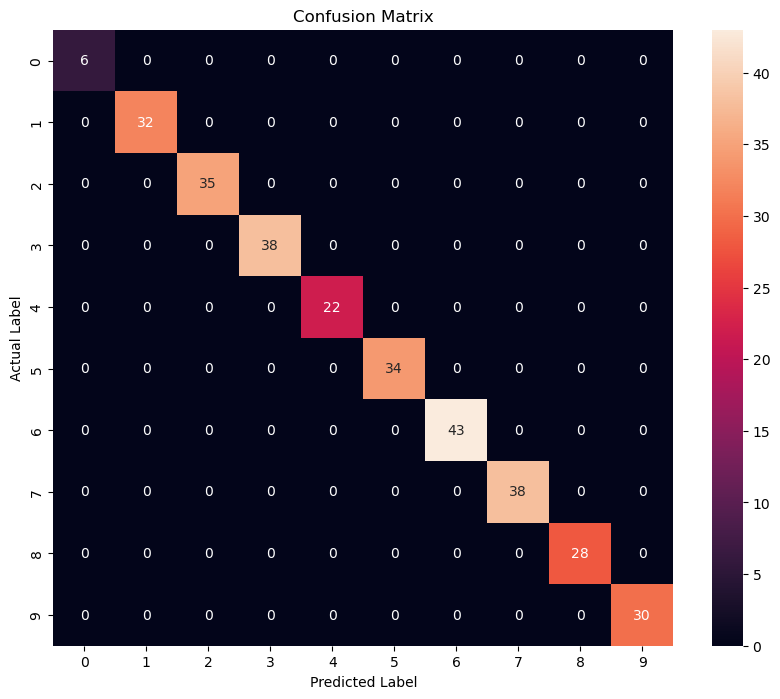

In [323]:
# Correct reshaping of the test data
X_test_reshaped = X_test_scaled.reshape(-1, 55, 55, 1)

# Make predictions using the reshaped test data
y_pred = final_model.predict(X_test_reshaped)

# Convert probabilities to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt="d")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("Actual Label")
ax.set_title("Confusion Matrix")
plt.show()

# Printing the classification report
report=classification_report(y_test, y_pred_classes, output_dict=True)

with open('results/CNN_classification_report.json', 'w') as f_json:
    json.dump(report, f_json, indent=4)



# Ranking The Models 

When evaluating multiple models like CNN, MLP, RandomForest, and XGBoost on a consistent set of test data, using the same X_test and y_test, ensures a rigorous and fair comparison. Since each model is subjected to the same conditions, their performance metrics—precision, recall, f1-score, and accuracy—can be directly compared against one another. In this context, the discrepancy is a measure of how much each model's performance deviates from the best possible score, which is 1.0 for the mentioned metrics.

Given that the test set is identical across models, this method of comparison guards against variability that could arise from models being tested on different segments of data. The approach is particularly strict in that it does not merely compare models to the average of their collective performance but against an idealized standard of perfection. Consequently, models are ranked based on their closeness to this ideal, ensuring that only models with a significant drop in performance compared to this high standard are penalized. This maintains a rigorous assessment and ensures that all models are held to the same high standard of performance, providing a clear benchmark for what constitutes an underperforming model.

In [324]:
import json
import numpy as np

def load_classification_report(json_path):
    with open(json_path, 'r') as file:
        return json.load(file)

def aggregate_model_scores(report):
    # Calculate aggregated metrics.
    return {
        'f1-score': report['macro avg']['f1-score'],
        'recall': report['macro avg']['recall'],
        'precision': report['macro avg']['precision'],
        'accuracy': report['accuracy']
    }

def calculate_discrepancies_from_perfect(models_scores):
    # Calculate the discrepancy of each model from the perfect score.
    perfect_score = 1.0
    discrepancies = {
        model: np.mean([perfect_score - score for score in model_scores.values()])
        for model, model_scores in models_scores.items()
    }
    return discrepancies

def compare_models(model_reports):
    model_scores = {}
    model_names = ['CNN', 'MLP', 'Random Forest', 'XGBoost']

    # Load and aggregate scores for each model
    for model_name, report_path in zip(model_names, model_reports):
        report = load_classification_report(report_path)
        model_scores[model_name] = aggregate_model_scores(report)

    # Calculate discrepancies for each model from the perfect score
    discrepancies = calculate_discrepancies_from_perfect(model_scores)

    # Rank the models based on the discrepancy (lower is better, closer to perfect score)
    sorted_models = sorted(discrepancies.items(), key=lambda x: x[1])

    # Print the ranking of the models
    print("Ranking of models based on being closest to perfect score:")
    for rank, (model, discrepancy) in enumerate(sorted_models, start=1):
        print(f"Rank {rank}: {model} with Discrepancy Score: {discrepancy:.4f}")

    # Return the best model based on smallest discrepancy from perfect score
    best_model = sorted_models[0][0]
    return best_model

# Paths to the classification report JSON files for each model
report_paths = [
    'results/CNN_classification_report.json',
    'results/MLP_classification_report.json',
    'results/RF_classification_report.json',
    'results/XGBoost_classification_report.json'
]

# Call the function and print the best model
best_model = compare_models(report_paths)
print(f"The best model is: {best_model}")


Ranking of models based on being closest to perfect score:
Rank 1: CNN with Discrepancy Score: 0.0000
Rank 2: Random Forest with Discrepancy Score: 0.0000
Rank 3: XGBoost with Discrepancy Score: 0.0035
Rank 4: MLP with Discrepancy Score: 0.0128
The best model is: CNN


According to our model CNN and random Forest score a perfect score but we will chose CNN to continue with our application as it is the latest concept we studied